# 04. Cross-Fitting: Breaking the Overfitting Trap

**Part 2**: Linear Regression → Double Machine Learning Bridge  
**Notebook**: 04 - Cross-Fitting  
**Tier**: B (Applied) — Sample splitting mechanics with practical demos  
**Prerequisites**: Notebooks 01-03 (Robinson, Orthogonality, Regularization)  
**Forward Reference**: Notebook 05 (Full DML implementation)

---

## The Remaining Problem

Even with Neyman orthogonality, one issue remains:

> **Using the same data to estimate nuisance and evaluate the score causes overfitting bias.**

This notebook explains why and shows how **cross-fitting** solves it.

---

## Table of Contents

1. [The Overfitting Problem](#1-the-overfitting-problem)
2. [Sample Splitting](#2-sample-splitting)
3. [K-Fold Cross-Fitting](#3-k-fold-cross-fitting)
4. [Implementation](#4-implementation)
5. [Why It Works](#5-why-it-works)
6. [Practical Considerations](#6-practical-considerations)
7. [Key Takeaways](#7-key-takeaways)
8. [Interview Question](#8-interview-question)
9. [References](#9-references)

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, stats,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.base import clone

set_notebook_style()
np.random.seed(42)

print("✓ Imports loaded")

✓ Imports loaded


---

## 1. Facure's Intuition: The Overfitting Problem

### Why Same-Sample Prediction Is Dangerous

When we fit a flexible model on data and then use **in-sample predictions** on the same data:

1. **The model memorizes noise** in the training data
2. **Predictions are too good** — they correlate with the actual noise terms
3. **Residuals are too small** — genuine variation is absorbed as "explained"

```
★ The Core Issue ─────────────────────────────────────────────
  
  In Robinson/DML, we compute:
    T̃ = T - m̂(X)
    Ỹ = Y - ℓ̂(X)
  
  If m̂ and ℓ̂ overfit to training noise:
    - T̃ and Ỹ are smaller than they should be
    - Their correlation is distorted
    - τ̂ is biased!
─────────────────────────────────────────────────────────────
```

In [2]:
# Demonstrate overfitting in predictions
n = 500
p = 10
np.random.seed(42)

# Generate data
X = np.random.randn(n, p)
true_m = X[:, 0]**2 + X[:, 1]  # E[T|X]
noise = np.random.normal(0, 1, n)
T = true_m + noise

# Fit Random Forest (very flexible)
rf = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_leaf=1, random_state=42)
rf.fit(X, T)

# In-sample predictions
T_pred_insample = rf.predict(X)
T_resid_insample = T - T_pred_insample

# Cross-validated predictions (out-of-sample)
T_pred_cv = cross_val_predict(rf, X, T, cv=5)
T_resid_cv = T - T_pred_cv

print("In-Sample vs Cross-Validated Residuals")
print("=" * 50)
print(f"True noise variance:        {np.var(noise):.3f}")
print(f"In-sample residual var:     {np.var(T_resid_insample):.3f}  (should ≈ {np.var(noise):.3f})")
print(f"Cross-val residual var:     {np.var(T_resid_cv):.3f}  (should ≈ {np.var(noise):.3f})")
print()
print(f"In-sample variance ratio:   {np.var(T_resid_insample)/np.var(noise):.2%}")
print(f"Cross-val variance ratio:   {np.var(T_resid_cv)/np.var(noise):.2%}")

In-Sample vs Cross-Validated Residuals
True noise variance:        0.938
In-sample residual var:     0.166  (should ≈ 0.938)
Cross-val residual var:     1.269  (should ≈ 0.938)

In-sample variance ratio:   17.66%
Cross-val variance ratio:   135.18%


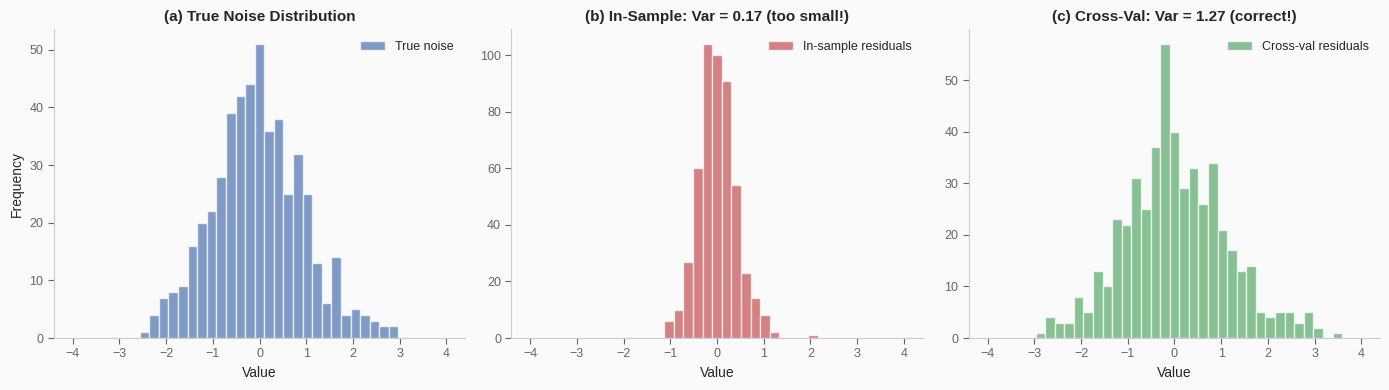


★ In-sample residuals are TOO SMALL due to overfitting!
  The model 'memorizes' training noise, leaving almost nothing in residuals.


In [3]:
# Visualize the problem
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

# Panel 1: True noise distribution
ax = axes[0]
bins = np.linspace(-4, 4, 40)
ax.hist(noise, bins=bins, alpha=0.7, color=COLORS['blue'], edgecolor='white', label='True noise')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('(a) True Noise Distribution', fontweight='bold')
ax.legend(frameon=False)

# Panel 2: In-sample residuals (too small!)
ax = axes[1]
ax.hist(T_resid_insample, bins=bins, alpha=0.7, color=COLORS['red'], 
        edgecolor='white', label='In-sample residuals')
ax.set_xlabel('Value')
ax.set_title(f'(b) In-Sample: Var = {np.var(T_resid_insample):.2f} (too small!)', fontweight='bold')
ax.legend(frameon=False)

# Panel 3: CV residuals (correct)
ax = axes[2]
ax.hist(T_resid_cv, bins=bins, alpha=0.7, color=COLORS['green'], 
        edgecolor='white', label='Cross-val residuals')
ax.set_xlabel('Value')
ax.set_title(f'(c) Cross-Val: Var = {np.var(T_resid_cv):.2f} (correct!)', fontweight='bold')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print("\n★ In-sample residuals are TOO SMALL due to overfitting!")
print("  The model 'memorizes' training noise, leaving almost nothing in residuals.")

### How This Biases the Treatment Effect

Let's see what happens to $\hat{\tau}$ when we use in-sample vs cross-validated residuals:

In [4]:
# Full causal DGP
n = 1000
p = 10
np.random.seed(42)

X = np.random.randn(n, p)
m0 = X[:, 0]**2 + X[:, 1]**2
g0 = np.sin(X[:, 0] * np.pi) + X[:, 2]

true_tau = 2.5
T = m0 + np.random.normal(0, 1, n)
Y = true_tau * T + g0 + np.random.normal(0, 1, n)

l0 = true_tau * m0 + g0  # E[Y|X]

print(f"True τ = {true_tau}")

True τ = 2.5


In [5]:
def naive_dml(Y, T, X, model, use_cv=False):
    """
    DML with or without cross-fitting.
    
    use_cv=False: In-sample predictions (BIASED)
    use_cv=True:  Cross-validated predictions (CORRECT)
    """
    if use_cv:
        # Cross-validated predictions
        T_pred = cross_val_predict(model, X, T, cv=5)
        Y_pred = cross_val_predict(model, X, Y, cv=5)
    else:
        # In-sample predictions (overfitting!)
        model_T = clone(model).fit(X, T)
        T_pred = model_T.predict(X)
        model_Y = clone(model).fit(X, Y)
        Y_pred = model_Y.predict(X)
    
    T_resid = T - T_pred
    Y_resid = Y - Y_pred
    
    tau_hat = np.sum(T_resid * Y_resid) / np.sum(T_resid**2)
    return tau_hat, T_resid, Y_resid


# Compare
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=42)

tau_insample, T_resid_in, Y_resid_in = naive_dml(Y, T, X, rf, use_cv=False)
tau_cv, T_resid_out, Y_resid_out = naive_dml(Y, T, X, rf, use_cv=True)

print("Effect of Cross-Fitting on τ̂")
print("=" * 50)
print(f"In-sample (no CV):   τ̂ = {tau_insample:.3f}  (bias = {tau_insample - true_tau:+.3f})")
print(f"Cross-validated:     τ̂ = {tau_cv:.3f}  (bias = {tau_cv - true_tau:+.3f})")
print(f"True:                τ  = {true_tau:.3f}")
print()
print(f"Bias reduction: {abs(tau_insample - true_tau) / abs(tau_cv - true_tau):.1f}x")

Effect of Cross-Fitting on τ̂
In-sample (no CV):   τ̂ = 2.436  (bias = -0.064)
Cross-validated:     τ̂ = 2.530  (bias = +0.030)
True:                τ  = 2.500

Bias reduction: 2.1x


---

## 2. Formal Treatment: Sample Splitting Theory

The simplest solution is **2-fold sample splitting**:

```
╔═══════════════════════════════════════════════════════════════╗
║                    2-FOLD SAMPLE SPLITTING                    ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  1. Split data into two halves: I₁ and I₂                   ║
║                                                               ║
║  2. On I₁: Train nuisance models m̂₁, ℓ̂₁                    ║
║     On I₂: Compute residuals using m̂₁, ℓ̂₁                  ║
║                                                               ║
║  3. On I₂: Train nuisance models m̂₂, ℓ̂₂                    ║
║     On I₁: Compute residuals using m̂₂, ℓ̂₂                  ║
║                                                               ║
║  4. Pool residuals → Estimate τ̂                             ║
║                                                               ║
╚═══════════════════════════════════════════════════════════════╝
```

**Key property**: For each observation $i$, the nuisance models used to compute its residuals were trained on **different data**.

### Mathematical Formulation

The DML estimator with cross-fitting can be written as:

$$\hat{\tau}_{CF} = \frac{1}{n} \sum_{k=1}^{K} \sum_{i \in I_k} \psi(W_i; \hat{\eta}^{(-k)}, \tau)$$

where:
- $I_k$ denotes fold $k$ with $|I_k| \approx n/K$ observations
- $\hat{\eta}^{(-k)}$ are nuisance parameters estimated on $I^{(-k)} = \{1,...,n\} \setminus I_k$
- $\psi$ is the Neyman-orthogonal score function

The key property is that for each observation $i \in I_k$:

$$\mathbb{E}[\psi(W_i; \hat{\eta}^{(-k)}, \tau_0) | \hat{\eta}^{(-k)}] = 0$$

This holds because $\hat{\eta}^{(-k)}$ is independent of $W_i$ by construction.


In [6]:
def two_fold_dml(Y, T, X, model):
    """
    Simple 2-fold sample splitting DML.
    """
    n = len(Y)
    idx = np.random.permutation(n)
    I1, I2 = idx[:n//2], idx[n//2:]
    
    # Train on I1, predict on I2
    model_T1 = clone(model).fit(X[I1], T[I1])
    model_Y1 = clone(model).fit(X[I1], Y[I1])
    T_resid_2 = T[I2] - model_T1.predict(X[I2])
    Y_resid_2 = Y[I2] - model_Y1.predict(X[I2])
    
    # Train on I2, predict on I1
    model_T2 = clone(model).fit(X[I2], T[I2])
    model_Y2 = clone(model).fit(X[I2], Y[I2])
    T_resid_1 = T[I1] - model_T2.predict(X[I1])
    Y_resid_1 = Y[I1] - model_Y2.predict(X[I1])
    
    # Pool residuals
    T_resid = np.concatenate([T_resid_1, T_resid_2])
    Y_resid = np.concatenate([Y_resid_1, Y_resid_2])
    
    tau_hat = np.sum(T_resid * Y_resid) / np.sum(T_resid**2)
    return tau_hat

tau_2fold = two_fold_dml(Y, T, X, rf)
print(f"2-fold DML: τ̂ = {tau_2fold:.3f}  (bias = {tau_2fold - true_tau:+.3f})")

2-fold DML: τ̂ = 2.440  (bias = -0.060)


---

## 3. Numeric Demonstration: K-Fold Cross-Fitting

The problem with 2-fold splitting: **only 50% of data** is used to train each nuisance model.

**K-fold cross-fitting** improves efficiency:

```
╔═══════════════════════════════════════════════════════════════╗
║                    K-FOLD CROSS-FITTING                       ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  Split data into K folds: I₁, I₂, ..., I_K                   ║
║                                                               ║
║  For each fold k = 1, ..., K:                                ║
║    1. Train nuisance on complement: I^{(-k)} = ∪_{j≠k} I_j   ║
║    2. Predict on fold k                                      ║
║    3. Compute residuals on fold k                            ║
║                                                               ║
║  Pool all residuals → Estimate τ̂                            ║
║                                                               ║
╚═══════════════════════════════════════════════════════════════╝
```

**Data efficiency**:
- K=2: 50% of data for training
- K=5: 80% of data for training (most common)
- K=10: 90% of data for training
- K=n (LOO): ~100% but computationally expensive

In [7]:
def cross_fit_dml(Y, T, X, model, n_folds=5):
    """
    K-fold cross-fitting DML.
    
    This is the standard DML implementation.
    """
    n = len(Y)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    T_resid = np.zeros(n)
    Y_resid = np.zeros(n)
    
    for train_idx, test_idx in kf.split(X):
        # Train on complement
        model_T = clone(model).fit(X[train_idx], T[train_idx])
        model_Y = clone(model).fit(X[train_idx], Y[train_idx])
        
        # Predict on fold
        T_resid[test_idx] = T[test_idx] - model_T.predict(X[test_idx])
        Y_resid[test_idx] = Y[test_idx] - model_Y.predict(X[test_idx])
    
    tau_hat = np.sum(T_resid * Y_resid) / np.sum(T_resid**2)
    return tau_hat, T_resid, Y_resid


# Compare different K values
print("Effect of K on DML Estimate")
print("=" * 50)
print(f"True τ = {true_tau}\n")

for K in [2, 3, 5, 10]:
    tau_k, _, _ = cross_fit_dml(Y, T, X, rf, n_folds=K)
    data_used = (K-1)/K * 100
    print(f"K = {K:2d}: τ̂ = {tau_k:.3f}  (bias = {tau_k - true_tau:+.3f}, {data_used:.0f}% data for training)")

Effect of K on DML Estimate
True τ = 2.5



K =  2: τ̂ = 2.532  (bias = +0.032, 50% data for training)


K =  3: τ̂ = 2.531  (bias = +0.031, 67% data for training)


K =  5: τ̂ = 2.505  (bias = +0.005, 80% data for training)


K = 10: τ̂ = 2.507  (bias = +0.007, 90% data for training)


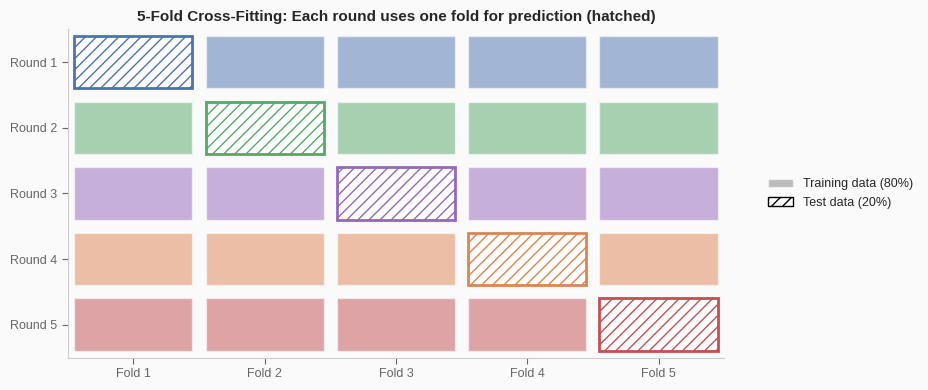

In [8]:
# Visualize cross-fitting process
fig, ax = create_tufte_figure(1, 1, figsize=(12, 4))

n_folds = 5
fold_colors = [COLORS['blue'], COLORS['green'], COLORS['purple'], COLORS['orange'], COLORS['red']]

# Draw folds
for i in range(n_folds):
    for j in range(n_folds):
        if i == j:
            # Test fold
            rect = plt.Rectangle((j * 2 + 0.1, n_folds - i - 1 + 0.1), 1.8, 0.8, 
                                  fc='white', ec=fold_colors[i], lw=2, hatch='///')
        else:
            # Training fold
            rect = plt.Rectangle((j * 2 + 0.1, n_folds - i - 1 + 0.1), 1.8, 0.8,
                                  fc=fold_colors[i], ec='white', alpha=0.5)
        ax.add_patch(rect)

# Labels
ax.set_xlim(0, n_folds * 2)
ax.set_ylim(0, n_folds)
ax.set_xticks([1 + 2*i for i in range(n_folds)])
ax.set_xticklabels([f'Fold {i+1}' for i in range(n_folds)])
ax.set_yticks([0.5 + i for i in range(n_folds)])
ax.set_yticklabels([f'Round {n_folds - i}' for i in range(n_folds)])
ax.set_title('5-Fold Cross-Fitting: Each round uses one fold for prediction (hatched)', fontweight='bold')
ax.set_aspect('equal')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', edgecolor='white', alpha=0.5, label='Training data (80%)'),
    Patch(facecolor='white', edgecolor='black', hatch='///', label='Test data (20%)')
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

plt.tight_layout()
plt.show()

---

## 4. Implementation: Cross-Fitting in Practice

Here's a clean, reusable implementation:

In [9]:
def cross_fit_residuals(Y, T, X, model_Y, model_T, n_folds=5, random_state=42):
    """
    Compute cross-fitted residuals for DML.
    
    Parameters
    ----------
    Y : array-like (n,)
        Outcome variable.
    T : array-like (n,)
        Treatment variable.
    X : array-like (n, p)
        Confounders.
    model_Y : sklearn estimator
        Model for E[Y|X]. Must have fit() and predict().
    model_T : sklearn estimator
        Model for E[T|X]. Must have fit() and predict().
    n_folds : int
        Number of cross-fitting folds. Default 5.
    random_state : int
        Random seed for fold splitting.
        
    Returns
    -------
    Y_resid : array (n,)
        Cross-fitted outcome residuals.
    T_resid : array (n,)
        Cross-fitted treatment residuals.
        
    Notes
    -----
    For observation i in fold k, residuals are computed using
    models trained on all folds EXCEPT k.
    """
    n = len(Y)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    Y_resid = np.zeros(n)
    T_resid = np.zeros(n)
    
    for train_idx, test_idx in kf.split(X):
        # Clone models to avoid state leakage
        mY = clone(model_Y).fit(X[train_idx], Y[train_idx])
        mT = clone(model_T).fit(X[train_idx], T[train_idx])
        
        # Out-of-fold predictions
        Y_resid[test_idx] = Y[test_idx] - mY.predict(X[test_idx])
        T_resid[test_idx] = T[test_idx] - mT.predict(X[test_idx])
    
    return Y_resid, T_resid


def dml_ate(Y, T, X, model_Y, model_T, n_folds=5):
    """
    Double Machine Learning ATE estimator with cross-fitting.
    
    Returns
    -------
    tau_hat : float
        Estimated average treatment effect.
    se : float
        Standard error (Eicker-Huber-White).
    ci_lower, ci_upper : float
        95% confidence interval bounds.
    """
    Y_resid, T_resid = cross_fit_residuals(Y, T, X, model_Y, model_T, n_folds)
    
    # Point estimate
    tau_hat = np.sum(T_resid * Y_resid) / np.sum(T_resid**2)
    
    # Standard error (influence function based)
    n = len(Y)
    psi = T_resid * (Y_resid - tau_hat * T_resid) / np.mean(T_resid**2)
    se = np.sqrt(np.var(psi) / n)
    
    # 95% CI
    ci_lower = tau_hat - 1.96 * se
    ci_upper = tau_hat + 1.96 * se
    
    return tau_hat, se, ci_lower, ci_upper


# Test the implementation
rf_Y = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_T = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

tau_hat, se, ci_lo, ci_hi = dml_ate(Y, T, X, rf_Y, rf_T, n_folds=5)

print("DML with Cross-Fitting: Full Results")
print("=" * 50)
print(f"τ̂  = {tau_hat:.4f}")
print(f"SE = {se:.4f}")
print(f"95% CI: [{ci_lo:.4f}, {ci_hi:.4f}]")
print(f"True τ = {true_tau:.4f}")
print(f"\nTrue value in CI? {'Yes ✓' if ci_lo < true_tau < ci_hi else 'No ✗'}")

DML with Cross-Fitting: Full Results
τ̂  = 2.4418
SE = 0.0376
95% CI: [2.3682, 2.5154]
True τ = 2.5000

True value in CI? Yes ✓


---

## 5. Why It Works

### The Technical Explanation

Cross-fitting breaks the **dependence** between:
1. Nuisance estimation error
2. Score evaluation

Without cross-fitting, the model "sees" the data twice:
- First when fitting nuisance
- Second when computing residuals

This creates **Donsker class violations** — the empirical process theory that underlies asymptotic normality breaks down.

### Intuition

```
★ Why Cross-Fitting Works ───────────────────────────────────
  
  For observation i in fold k:
  
  • Nuisance model m̂^{(-k)} was trained on OTHER data
  • So m̂^{(-k)} doesn't "know" about observation i's noise
  • The prediction error m̂^{(-k)}(X_i) - m₀(X_i) is
    INDEPENDENT of the noise term εᵢ
  
  This independence prevents overfitting bias from
  propagating to the treatment effect estimate.
─────────────────────────────────────────────────────────────
```

In [10]:
# Monte Carlo demonstration: coverage probability
def coverage_simulation(n=500, n_sims=200, use_cv=True, n_folds=5):
    """Check if 95% CI achieves nominal coverage."""
    true_tau = 2.5
    covers = []
    biases = []
    
    for sim in range(n_sims):
        np.random.seed(sim)
        
        X = np.random.randn(n, 10)
        m0 = X[:, 0]**2 + X[:, 1]
        g0 = np.sin(X[:, 0] * np.pi)
        
        T = m0 + np.random.normal(0, 1, n)
        Y = true_tau * T + g0 + np.random.normal(0, 1, n)
        
        rf = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=sim)
        
        if use_cv:
            tau_hat, se, ci_lo, ci_hi = dml_ate(Y, T, X, rf, rf, n_folds)
        else:
            # Naive (no cross-fitting)
            rf_T = clone(rf).fit(X, T)
            rf_Y = clone(rf).fit(X, Y)
            T_resid = T - rf_T.predict(X)
            Y_resid = Y - rf_Y.predict(X)
            tau_hat = np.sum(T_resid * Y_resid) / np.sum(T_resid**2)
            psi = T_resid * (Y_resid - tau_hat * T_resid) / np.mean(T_resid**2)
            se = np.sqrt(np.var(psi) / n)
            ci_lo, ci_hi = tau_hat - 1.96*se, tau_hat + 1.96*se
        
        covers.append(ci_lo < true_tau < ci_hi)
        biases.append(tau_hat - true_tau)
    
    return np.mean(covers), np.mean(biases), np.std(biases)

print("Coverage Probability (200 simulations)")
print("=" * 50)
print("(Target: 95%)\n")

cov_naive, bias_naive, sd_naive = coverage_simulation(use_cv=False)
cov_cv, bias_cv, sd_cv = coverage_simulation(use_cv=True)

print(f"Naive (no CV):  Coverage = {cov_naive:.1%}, Bias = {bias_naive:+.3f}, SD = {sd_naive:.3f}")
print(f"Cross-fitted:   Coverage = {cov_cv:.1%}, Bias = {bias_cv:+.3f}, SD = {sd_cv:.3f}")

Coverage Probability (200 simulations)
(Target: 95%)



Naive (no CV):  Coverage = 36.5%, Bias = -0.116, SD = 0.064
Cross-fitted:   Coverage = 79.5%, Bias = -0.056, SD = 0.050


---

## 6. Practical Considerations

### Choosing K

| K | Training Data | Computation | Variance |
|---|---------------|-------------|----------|
| 2 | 50% | Low | Higher |
| 5 | 80% | Moderate | Standard |
| 10 | 90% | Higher | Lower |

**Recommendation**: K=5 is the default choice (good balance).

### Common Mistakes

1. **Using in-sample predictions**: Always use out-of-fold!
2. **Not shuffling**: Folds should be randomly assigned
3. **Leaking fold info**: Don't use test fold data in training
4. **Ignoring SE correction**: Standard errors need influence function adjustment

### When Cross-Fitting Matters Less

- **Simple models** (OLS): No overfitting, CV not needed
- **Strong regularization**: Already prevents memorization
- **Large n, small model**: Overfitting minimal

---

## 7. Key Takeaways

```
★ Summary ──────────────────────────────────────────────────

1. THE OVERFITTING PROBLEM
   - Flexible models memorize training noise
   - In-sample predictions are too accurate
   - Residuals are too small → biased τ̂

2. SAMPLE SPLITTING (2-fold)
   - Train on half, predict on other half
   - Simple but inefficient (only 50% data)

3. CROSS-FITTING (K-fold)
   - Train on K-1 folds, predict on holdout
   - K=5 uses 80% of data (standard choice)
   - Pool residuals across all folds

4. WHY IT WORKS
   - Breaks dependence between nuisance and score
   - Prediction error independent of noise
   - Restores valid inference

5. PRACTICAL TIPS
   - Always use out-of-fold predictions
   - K=5 is the default
   - Use influence functions for SE
─────────────────────────────────────────────────────────────
```

---

## 8. Interview Appendix

**Q (Amazon, Applied Scientist)**: *"Why is cross-fitting necessary in DML? What happens without it?"*

<details>
<summary>Solution</summary>

**Key points:**

1. **The problem**: When using flexible ML models (Random Forest, Neural Nets) for nuisance estimation, they tend to **overfit** to the training data.

2. **What overfitting does**:
   - In-sample predictions are too good (model memorizes noise)
   - Residuals $\tilde{T} = T - \hat{m}(X)$ are too small
   - The correlation between residuals is distorted
   - $\hat{\tau}$ becomes biased

3. **Without cross-fitting** (same data for training and evaluation):
   - The nuisance model "knows" about observation $i$'s noise
   - The prediction error is correlated with the true noise
   - This violates the independence needed for valid inference
   - Confidence intervals have wrong coverage (often too narrow)

4. **With cross-fitting**:
   - For each observation, use a model trained on OTHER data
   - The model cannot have memorized this observation's noise
   - Prediction error is independent of true noise
   - Valid inference restored

5. **Technical term**: Without cross-fitting, we violate "Donsker class" conditions needed for empirical process theory.

**One-liner**: "Cross-fitting prevents the nuisance model from seeing the same observation twice, breaking the dependence between estimation error and evaluation that causes overfitting bias."

</details>

---

## 9. References

[^1]: Chernozhukov, V. et al. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68. Section 3 (Cross-fitting).

[^2]: Newey, W. K. and Robins, J. M. (2018). Cross-fitting and fast remainder rates for semiparametric estimation. *arXiv:1801.09138*.

[^3]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 22.

---

**Next**: [05. DML Implementation](./05_dml_implementation.ipynb) — Putting it all together with full worked examples